# pyPLNmodels Overview

pyPLNmodels is a Python package that simplifies the analysis of multivariate, high-dimensional count data using Poisson Lognormal models. It offers a variety of tools for model fitting, clustering, visualization, and inference.

This notebook demonstrates some of the features of the package. For a statistical description, you may see the [documentation](https://pypi.org/project/pyPLNmodels/). 

In this tutorial, we focus on the fact that the count variables, `endog`, are determined by less noisy `latent_variables`. The package infers these `latent_variables` to help reduce noise and improve the quality of the data.


### Package installation

In [ ]:
!pip install pyPLNmodels

### Loading data

The package comes with a single-cell RNA sequencing dataset to present the functionalities:

In [32]:
from pyPLNmodels import load_scrna

data = load_scrna()
print("Keys:", data.keys())

Returning scRNA dataset of size (400, 100)
Keys: dict_keys(['endog', 'labels', 'labels_1hot'])


This dataset contains the number of occurrences of each gene in each cell in
`data["endog"]`. Each cell is labelled by its cell-type in `data["labels"]`.

In [33]:
data["endog"].describe()

,FTL,MALAT1,FTH1,TMSB4X,CD74,SPP1,APOE,B2M,ACTB,HLA-DRA,...,RPS15,ACTG1,RPL3,TIMP1,RPL15,RPL30,RPL12,CCL3L1,S100A8,NPC2
count,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,53.812500,120.03250,30.950000,61.335000,31.352500,7.777500,8.720000,53.380000,31.382500,20.807500,...,11.072500,6.415000,10.575000,1.45250,9.152500,10.317500,9.560000,0.517500,1.295000,3.315000
std,223.516501,117.78444,72.127619,81.243332,81.850822,57.400829,47.140717,53.022203,54.820566,56.922411,...,11.094592,10.301849,10.843585,6.28223,11.281286,9.741609,10.399605,3.185131,7.313802,9.167655
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,39.00000,2.000000,17.750000,1.000000,0.000000,0.000000,20.750000,4.000000,0.000000,...,3.000000,1.000000,3.000000,0.00000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
50%,4.000000,97.00000,6.000000,37.500000,3.000000,0.000000,0.000000,42.000000,13.000000,1.000000,...,9.000000,3.000000,7.500000,0.00000,6.000000,8.000000,6.500000,0.000000,0.000000,0.000000
75%,14.000000,171.00000,22.000000,74.000000,16.000000,0.000000,1.000000,64.000000,33.000000,7.000000,...,15.000000,7.000000,15.000000,1.00000,11.000000,14.000000,13.000000,0.000000,0.000000,1.000000
max,3489.000000,1171.00000,620.000000,833.000000,619.000000,739.000000,569.000000,429.000000,391.000000,429.000000,...,68.000000,76.000000,84.000000,85.00000,90.000000,69.000000,71.000000,34.000000,102.000000,90.000000


In [34]:
data["labels"].describe()

count              400
unique               3
top       T_cells_CD8+
freq               162
Name: standard_true_celltype_v5, dtype: object

### How to specify a model

Each model can be specified in two distinct manners:

* by formula (similar to R), where a data frame is passed and the formula is specified using the `from_formula` initialization:

In [35]:
from pyPLNmodels import Pln

pln = Pln.from_formula("endog ~ 1  + labels ", data=data)

Setting the offsets to zero.


We rely on the [patsy](https://github.com/pydata/patsy) package for the formula parsing.

* by specifying the `endog`, `exog`, and `offsets` matrices directly:


In [36]:
import numpy as np

endog = data["endog"]
exog = data["labels"]
offsets = np.zeros((endog.shape))
pln = Pln(endog=endog, exog=exog, offsets=offsets)

The parameters `exog` and `offsets` are optional. By default,
`exog` is set to represent an intercept, which is a vector of ones. Similarly,
`offsets` defaults to a matrix of zeros. The `offsets` should be on the scale of the log of the counts.

### Motivation

Suppose we try to infer the cell type of each cell, using Linear Discriminant Analysis (LDA):

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


def get_classif_error(data, y):
    data_train, data_test, y_train, y_test = train_test_split(
        data, y, test_size=0.33, random_state=42
    )
    lda = LDA()
    lda.fit(data_train, y_train)
    y_pred = lda.predict(data_test)
    return np.mean(y_pred != y_test)

Training directly on the count variables gives: 

In [38]:
data = load_scrna(n_samples=1000)
get_classif_error(data["endog"], data["labels"])

Returning scRNA dataset of size (1000, 100)


0.31212121212121213

While training on the latent variables infered by the PLN models is much better: 

In [39]:
get_classif_error(Pln(data["endog"]).fit().latent_variables, data["labels"])

Upper bound on the fitting time:   4%| | 15/400 [00:00<00:02, 142.30

Setting the offsets to zero.
Fitting a Pln model with full covariance.
Intializing parameters ...
Initialization finished.


Upper bound on the fitting time:  99%|▉| 397/400 [00:04<00:00, 99.53

Maximum number of iterations (400)  reached in 4.1 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06


0.17575757575757575

### Covariance analysis with the Poisson lognormal model (aka `Pln`)

This is the building-block of the models implemented in this package. It fits a Poisson lognormal model to the data:


er bound on the fitting time:   0%|      | 0/400 [00:00<?, ?it/s]

Setting the offsets to zero.
Fitting a Pln model with full covariance.
Intializing parameters ...
Initialization finished.









































pper bound on the fitting time: 100%|█| 400/400 [00:04<00:00, 94.37

Maximum number of iterations (400)  reached in 4.1 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06
A multivariate Pln with full covariance.
     Loglike   Dimension    Nb param         BIC         AIC         ICL
   -226568.5         100        5350 245046.7454    231918.5    80324.89

* Useful attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional attributes for Pln are:
    None
* Additional methods for Pln are:
    .get_variance_coef() .get_confidence_interval_coef() .summary() .get_coef_p_values() .plot_regression_forest()



pper bound on the fitting time: 100%|█| 400/400 [00:10<00:00, 39.64

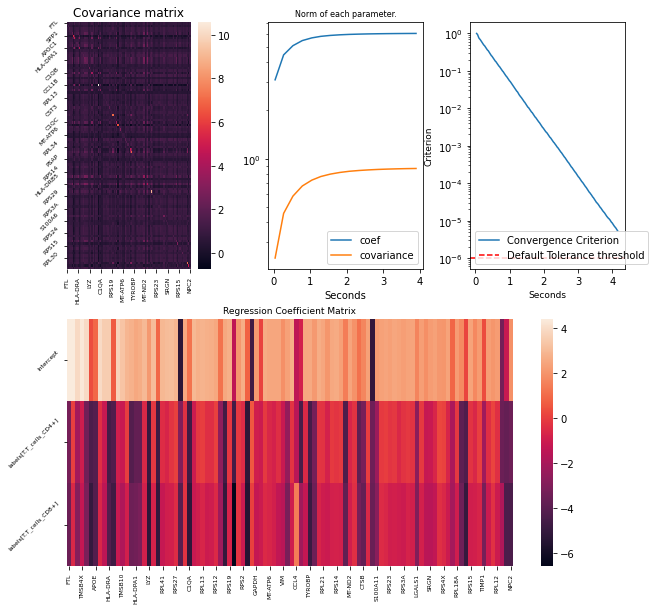

In [40]:
pln = Pln.from_formula("endog ~ 1  + labels ", data=data)
pln.fit()
print(pln)
transformed_data = pln.transform()
pln.show()

Note that for this specific model, variance estimation on the regression coefficients can be estimated and p-values can be obtained:

In [41]:
pln.summary()

Coefficients and p-values per dimension:

Dimension: FTL
Exog Name                Coefficient         P-value
Intercept                   4.402156           1e-16
labels[T.T_cells_CD4+]       -3.249073           1e-16
labels[T.T_cells_CD8+]       -3.561637           1e-16

Dimension: MALAT1
Exog Name                Coefficient         P-value
Intercept                   4.417019           1e-16
labels[T.T_cells_CD4+]        0.032829            0.76
labels[T.T_cells_CD8+]       -0.569526         3.2e-09

Dimension: FTH1
Exog Name                Coefficient         P-value
Intercept                   3.860034           1e-16
labels[T.T_cells_CD4+]       -2.069193           1e-16
labels[T.T_cells_CD8+]       -2.868554           1e-16

Dimension: TMSB4X
Exog Name                Coefficient         P-value
Intercept                   4.329525           1e-16
labels[T.T_cells_CD4+]       -0.983464           2e-09
labels[T.T_cells_CD8+]       -1.288844           1e-16

Dimension: CD74
Exog Na

### Dimension reduction with the PLN Principal Component Analysis (aka `PlnPCA` and `PlnPCACollection`)

This model excels in dimension reduction and is capable of scaling to
high-dimensional count data ($p >> 1$), by constraining the covariance matrix
$\Sigma$ to be of low rank (the larger the rank, the slower the model but the
better the approximation). The user may specify the rank when creating the
`PlnPCA` object:

In [42]:
from pyPLNmodels import PlnPCA

pca = PlnPCA.from_formula("endog ~ 1  + labels ", data=data, rank=3).fit()

Setting the offsets to zero.
Fitting a PlnPCA model with 3 principal components.
Intializing parameters ...


Upper bound on the fitting time:   4%| | 17/400 [00:00<00:02, 163.31

Initialization finished.


Upper bound on the fitting time: 100%|▉| 398/400 [00:03<00:00, 119.7

Maximum number of iterations (400)  reached in 3.7 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06


Multiple ranks can be simultaneously tested
within a single object (`PlnPCAcollection`), and select the optimal model.

Setting the offsets to zero.
Adjusting 3 PlnPCA models.

Fitting a PlnPCA model with 3 principal components.
Intializing parameters ...




er bound on the fitting time:   3%| | 13/400 [00:00<00:03, 120.22

Initialization finished.








































bound on the fitting time:   3%| | 12/400 [00:00<00:03, 111.33

Maximum number of iterations (400)  reached in 4.1 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 4 principal components.
Intializing parameters ...
Initialization finished.










































































nd on the fitting time:   3%| | 11/400 [00:00<00:03, 109.65

Maximum number of iterations (400)  reached in 3.6 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06
Fitting a PlnPCA model with 5 principal components.
Intializing parameters ...
Initialization finished.








































































































Upper bound on the fitting time: 100%|█| 400/400 [00:14<00:00, 27.04
Upper bound on the fitting time: 100%|█| 400/400 [00:11<00:00, 36.34
Upper bound on the fitting time: 100%|█| 400/400 [00:07<00:00, 54.57

pper bound on the fitting time: 100%|█| 400/400 [00:03<00:00, 107.9

Maximum number of iterations (400)  reached in 3.6 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06

DONE!
Best model (lower BIC): rank 3
    Best model(lower AIC): rank  4



----------------------------------------------------------------------
Collection of 3 PlnPCA models with 100 variables.
----------------------------------------------------------------------
 - rank considered: [3, 4, 5]
 - BIC criterion:      
        rank           3**           4           5
   criterion      356842      357063      357339

Best model (lower BIC): 3

 - AIC criterion:      
        rank           3           4**           5
   criterion      355377      355360      355401

   Best model (lower AIC): 4
----------------------------------------------------------------------
* Useful attributes
    ['.BIC', '.AIC', '.loglike']
* Useful methods
    ['.show()', '.best_model()', '.keys()', '.items()', '.values()']
----------------------------------------------------------------------


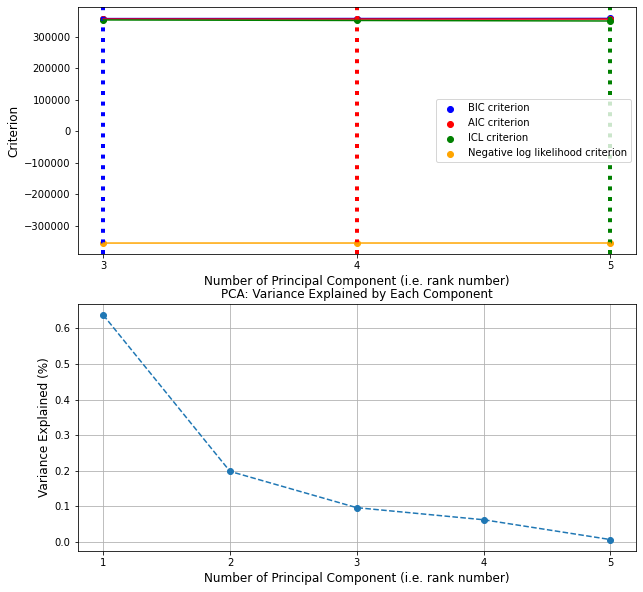

A multivariate PlnPCA with 3 principal components.
     Loglike   Dimension    Nb param         BIC         AIC         ICL
  -354780.25         100         597  356842.215   355377.25   352565.29

* Useful attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional attributes for PlnPCA are:
    None
* Additional methods for PlnPCA are:
    None


In [43]:
from pyPLNmodels import PlnPCACollection

pca_col = PlnPCACollection.from_formula(
    "endog ~ 1  + labels ", data=data, ranks=[3, 4, 5]
)
pca_col.fit()
print(pca_col)
pca_col.show()
best_pca = pca_col.best_model()
print(best_pca)

### Zero inflation with the Zero-Inflated PLN Model (aka `ZIPln` and `ZIPlnPCA`)

The `ZIPln` model, a variant of the PLN model, is designed to handle zero
inflation in the data. This model is particularly beneficial when the data contains a significant
number of zeros. It incorporates additional covariates for the zero inflation
coefficient, which are specified following the pipe `|` symbol in the formula
or via the `exog_inflation` keyword. If not specified, it is set to the
covariates for the Poisson part. It has extra latent variables estimating the probability of zero inflation.

In [44]:
from pyPLNmodels import ZIPln

zi = ZIPln.from_formula("endog ~ 1 | 1 + labels", data=data).fit()
print(zi)
print("Transformed data shape: ", zi.transform().shape)
z_latent_variables = zi.transform()
w_latent_variables = zi.latent_prob
print(r"latent variables of PLN shape", z_latent_variables.shape)
print(r"latent variables of zero inflation probability shape", w_latent_variables.shape)

Setting the offsets to zero.
Fitting a ZIPln model with full covariance.
Intializing parameters ...


Upper bound on the fitting time:   2%| | 7/400 [00:00<00:06, 63.60it

Initialization finished.


Upper bound on the fitting time: 100%|▉| 399/400 [00:06<00:00, 65.64

Maximum number of iterations (400)  reached in 6.9 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06
A multivariate ZIPln with full covariance.
     Loglike   Dimension    Nb param         BIC         AIC         ICL
  -228611.25         100        5450 247434.8831   234061.25    86945.38

* Useful attributes
    .latent_variables .latent_positions .model_parameters .latent_parameters .optim_details
* Useful methods
    .transform() .show() .predict() .sigma() .projected_latent_variables() .plot_correlation_circle() .biplot() .viz() .pca_pairplot() .plot_expected_vs_true()
* Additional attributes for ZIPln are:
    .latent_prob
* Additional methods for ZIPln are:
    .viz_prob() .predict_prob_inflation() .pca_pairplot_prob()
Transformed data shape:  torch.Size([1000, 100])
latent variables of PLN shape torch.Size([1000, 100])
latent variables of zero inflation probability shape torch.Size([1000, 100])


Similar to the `PlnPCA` model, the `ZIPlnPCA` model is capable of dimension reduction, along with a `ZIPlnPCACollection` to get the right number of components (see the documentation https://github.com/PLN-team/pyPLNmodels/).

### Network inference with the `PlnNetwork` model

The `PlnNetwork` model is designed to infer the network structure of the data.
It creates a network where the nodes are the count variables and the edges
represent the correlation between them. The sparsity of the network is ensured
via the `penalty` keyword. The larger the penalty, the sparser the network.



er bound on the fitting time:   2%| | 9/400 [00:00<00:04, 85.08it

Setting the offsets to zero.
Fitting a PlnNetwork model with  penalty 2000.
Intializing parameters ...
Initialization finished.













































Upper bound on the fitting time: 100%|█| 400/400 [00:11<00:00, 35.60

Maximum number of iterations (400)  reached in 4.9 seconds.
Last  criterion = 5.39e-06 . Required tolerance = 1e-06




pper bound on the fitting time: 100%|█| 400/400 [00:05<00:00, 79.10

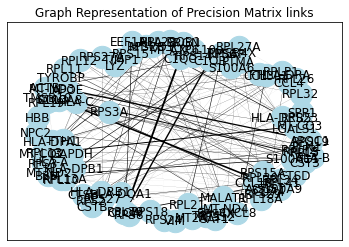

In [45]:
from pyPLNmodels import PlnNetwork

net = PlnNetwork.from_formula("endog ~ 1  + labels ", data=data, penalty=2000).fit()
net.viz_network()

In [46]:
print(net.network)

{'FTL': ['FTH1', 'HLA-B', 'PSAP', 'RPS29'], 'MALAT1': ['APOE', 'ACTB', 'MT-CO1', 'RPL41', 'RPS8'], 'FTH1': ['FTL', 'RPLP1', 'PTMA'], 'TMSB4X': ['B2M', 'ACTB', 'MT-CO1', 'RPS27', 'HLA-B', 'RPL13A', 'HLA-A', 'CCL4'], 'CD74': ['HLA-DRA', 'EEF1A1', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'C1QB', 'CCL3'], 'SPP1': ['MT-CO1', 'CTSD', 'CCL4', 'RPL32'], 'APOE': ['MALAT1', 'APOC1', 'RPL41', 'CCL18', 'C1QA', 'MT-ND4', 'C1QC'], 'B2M': ['TMSB4X', 'HLA-B', 'HLA-A', 'HLA-C'], 'ACTB': ['MALAT1', 'TMSB4X', 'VIM', 'RPL34', 'RPL21', 'PFN1', 'ACTG1'], 'HLA-DRA': ['CD74', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'TYROBP', 'PSAP', 'HLA-DQA1', 'MT-ND2'], 'APOC1': ['APOE', 'ACTG1', 'RPL3'], 'MT-CO1': ['MALAT1', 'TMSB4X', 'SPP1', 'MT-CO2', 'MT-CO3', 'MT-ND4', 'MT-ND3'], 'TMSB10': ['CCL18', 'TPT1', 'RPL39', 'S100A11', 'LGALS1', 'RPL26'], 'EEF1A1': ['CD74', 'RPL41', 'TPT1', 'RPL39', 'RPS6', 'RPS3A', 'RPS3'], 'HLA-DRB1': ['CD74', 'HLA-DRA', 'HLA-DPB1', 'HLA-DRB5', 'RPL26', 'HLA-DQB1'], 'HLA-DPA1': ['CD74', 'HLA-DRA', 'HLA

#### Multiple penalties can be given thanks to the `PlnNetworkCollection` (see the documentation https://github.com/PLN-team/pyPLNmodels/ ) and select the best model.

### Supervised clustering with the `PlnLDA` model

One can do supervised clustering using Linear Discriminant Analysis
designed for count data.

Upper bound on the fitting time:   3%| | 11/400 [00:00<00:03, 104.99

Setting the offsets to zero.
Fitting a PlnLDA model with full covariance.
Intializing parameters ...
Initialization finished.




er bound on the fitting time:  30%|▎| 15/50 [00:00<00:00, 144.90i

Maximum number of iterations (400)  reached in 1.8 seconds.
Last  criterion = 5.4e-06 . Required tolerance = 1e-06
Setting the offsets to zero.
Doing a VE step.








bound on the fitting time:  28%|▎| 14/50 [00:00<00:00, 132.67i

Done!
Setting the offsets to zero.
Doing a VE step.












nd on the fitting time:  28%|▎| 14/50 [00:00<00:00, 131.83i

Done!
Setting the offsets to zero.
Doing a VE step.








Upper bound on the fitting time: 100%|█| 50/50 [00:01<00:00, 39.99it
Upper bound on the fitting time: 100%|█| 50/50 [00:00<00:00, 58.93it

pper bound on the fitting time: 100%|█| 50/50 [00:00<00:00, 115.55i

Done!


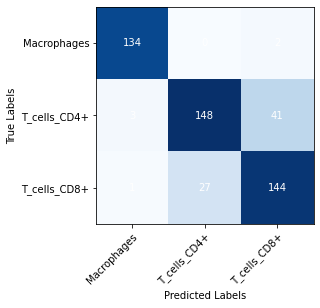


pper bound on the fitting time: 100%|█| 400/400 [00:03<00:00, 123.3

In [47]:
from pyPLNmodels import PlnLDA, plot_confusion_matrix

endog_train, endog_test = data["endog"][:500], data["endog"][500:]
labels_train, labels_test = data["labels"][:500], data["labels"][500:]
lda = PlnLDA(endog_train, clusters=labels_train).fit()
pred_test = lda.predict_clusters(endog_test)
plot_confusion_matrix(pred_test, labels_test)

### Unsupervised clustering with the `PlnMixture` model




Unsupervised clustering is another way to group similar observations in your data. This is useful when you do not have pre-labeled clusters.

In [ ]:
from pyPLNmodels import PlnMixture

mixture = PlnMixture(data["endog"].iloc[:, :10], n_cluster=3).fit()
mixture.show()

Upper bound on the fitting time:   0%|      | 0/150 [00:00<?, ?it/s]

Setting the offsets to zero.
Fitting a PlnMixture model with diagonal covariances and 3 clusters.
Intialization ...
Fitting a PlnDiag model with full covariance.
Intializing parameters ...
Initialization finished.


#### Multiple number of clusters can be specified thanks to the `PlnMixtureCollection` (see the documentation https://github.com/PLN-team/pyPLNmodels/) and select the best model.

### Autoregressive models with the `PlnAR` model

The `PlnAR` model is designed to handle time series data. It is a simple (one step) autoregressive model that can be used to predict the next time point.
(This assumes the endog variable is a time series, which is not the case in the example below)

In [ ]:
from pyPLNmodels import PlnAR

ar = PlnAR.from_formula("endog ~ 1  + labels ", data=data).fit()
ar.show()

### Visualization

The `.show()` method shows insights on the model. The `.viz()` method allows to visualize the latent variables. Many more visualization methods exists, and are listed when printing each model.

In [ ]:
pln.viz(colors=data["labels"])

In [ ]:
pln.biplot(column_names=["MALAT1", "RPL21", "CTSB"], colors=data["labels"])

### More functionalities

More functionalities, depending on the model, are implemented. You can see each of them by printing the model:

#### Pln

In [ ]:
print(pln)

#### `PlnPCA`

In [ ]:
print(pca)

##### `PlnPCACollection`

In [ ]:
print(pca_col)

#### `ZIPln`

In [ ]:
print(zi)

#### `PlnNetwork`

In [ ]:
print(net)

#### `PlnLDA`

In [ ]:
print(lda)

#### `PlnMixture`

In [ ]:
print(mixture)

#### `PlnAR`

In [ ]:
print(ar)

## 👐 Contributing

If you are interested in contributing to **`pyPLNmodels`**, feel free to submit a pull request. Make sure to read the [CONTRIBUTING.md](https://github.com/PLN-team/pyPLNmodels/blob/main/CONTRIBUTING.md) for the contribution guidelines. We will soon release a public roadmap to guide further development.

## ⚡️ Citations

If you use **pyPLNmodels**, please cite the following references:
- B. Batardiere, J.Kwon, J.Chiquet: *pyPLNmodels: A Python package to analyze multivariate high-dimensional count data.* [pdf](https://joss.theoj.org/papers/10.21105/joss.06969)
- J. Chiquet, M. Mariadassou and S. Robin: *Variational inference for probabilistic Poisson PCA, The Annals of Applied Statistics, 12: 2674–2698, 2018.* [pdf](http://dx.doi.org/10.1214/18%2DAOAS1177)
- B. Batardiere, J.Chiquet, M.Mariadassou: *Zero-inflation in the Multivariate Poisson Lognormal Family.* [pdf](https://arxiv.org/abs/2405.14711)
- B. Batardiere, J.Chiquet, M.Mariadassou: *Evaluating Parameter Uncertainty in the Poisson Lognormal Model with Corrected Variational Estimators.* [pdf](https://arxiv.org/abs/2411.08524)
- J. Chiquet, M. Mariadassou, S. Robin: *The Poisson-Lognormal Model as a Versatile Framework for the Joint Analysis of Species Abundances.* [pdf](https://www.frontiersin.org/journals/ecology-and-evolution/articles/10.3389/fevo.2021.588292/full)
- J. Chiquet, S. Robin, M. Mariadassou: *Variational Inference for sparse network reconstruction from count data* [pdf](https://proceedings.mlr.press/v97/chiquet19a.html)
